<a id='main'></a>

### Data & Folders
[Data &  Folders](#data_folders)

### Functions
[functions](#functions)

### Plots:
[main plot](#mainP)

[infectivity 0.15](#inf0.15)

[Performance of vaccination strategies with respect to deceased persons](#Performance)

[test plot](#test)

[0.1 sucseptibles](#01sus)

In [84]:
import os
#from VPM_plotting import *
from VPM_plotting_parallel import *
from virusPropagationModel import *

import VPM_plotting as vpm_plot
import get_status_data_and_plots_from_parallel as plt_para
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

from functools import partial

%matplotlib inline

<a id='data_folders'></a>
### Data &  Folders 

In [85]:
capacity_ICU_beds_germ = 30000 #(DIVI) optimistic number
germany_population = 83020000 # wiki
ICU_cap_per_100000 = capacity_ICU_beds_germ/germany_population*100000

In [86]:
defaultCmap = cm.get_cmap('Set2')
defaultCmap1 = cm.get_cmap('Set1')

In [87]:
server_data_folder_str = '/Volumes/Samsung_T5/corona_simulations/simulation_results_20201028/'
scenarios_list = os.listdir(server_data_folder_str)
scenarios_list.sort()
#scenarios_list

In [88]:
scenarios_list

['._plot_summary_all_scenarios.pptx',
 'LockDownLight',
 'additional_locations',
 'base_scenario',
 'base_scenario_inf_0.15',
 'close_all_336',
 'close_public_home_office_scan_0.2_0.9',
 'close_public_inf_0.15',
 'compliance_scan_0.00_0.45',
 'disobedience_scan_0.00_0.45',
 'fixed_base_scenario',
 'fixed_recover_age_scan_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_inf_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9',
 'fixed_recover_ageinteractions_scan_0.1_0.9',
 'fixed_recover_from_world_scan_0.1_0.9',
 'fixed_recover_household_scan_0.1_0.9',
 'fixed_recover_households_scan_0.1_0.9',
 'fixed_recover_interactions_scan_0.1_0.9',
 'fixed_recover_interactions_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_overrepresentation_scan_0.1_0.9',
 'fixed_recover_random_scan_0.1_0.9',
 'fixed_timecourses_for_network',
 'incidence_scan_LockDownLight',
 'incidence_scan_LockDownLight_2',
 'incidence_scan_control',
 'incidence_scan_

In [89]:
recover_list = [x for x in scenarios_list if x.startswith('recover_')]
recover_list

['recover_age_scan_0.1_0.9',
 'recover_age_scan_0.5_0.9',
 'recover_fromWorld_scan_0.5_0.9',
 'recover_from_world_scan_0.1_0.9',
 'recover_from_world_scan_0.1_0.9_inf_0.15',
 'recover_from_world_scan_0.1_0.9_inf_0.30',
 'recover_from_world_scan_0.5_0.9',
 'recover_from_world_scan_0.5_0.9_inf_0.15',
 'recover_from_world_scan_0.5_0.9_old',
 'recover_household_scan_0.1_0.9',
 'recover_household_scan_0.1_0.9_inf_0.15',
 'recover_household_scan_0.5_0.9',
 'recover_household_scan_0.5_0.9_old',
 'recover_interaction_scan_0.5_0.9',
 'recover_interaction_scan_0.5_0.9_old',
 'recover_interactions_scan_0.1_0.9',
 'recover_interactions_scan_0.1_0.9_inf_0.15',
 'recover_interactions_scan_0.1_0.9_inf_0.30',
 'recover_interactions_scan_0.5_0.9_inf_0.15',
 'recover_mix1_scan_0.1_0.9',
 'recover_mix1_scan_0.5_0.9',
 'recover_ordered1_0.5_0.9',
 'recover_ordered1_scan_0.1_0.9',
 'recover_ordered1_scan_0.5_0.9',
 'recover_ordered1_scan_0.5_0.9_old',
 'recover_pensioner_infectivity_0.15',
 'recover_random

In [90]:
fixed_recover_list = [x for x in scenarios_list if x.startswith('fixed_recover_')]
fixed_recover_list

['fixed_recover_age_scan_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_inf_0.1_0.9',
 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9',
 'fixed_recover_ageinteractions_scan_0.1_0.9',
 'fixed_recover_from_world_scan_0.1_0.9',
 'fixed_recover_household_scan_0.1_0.9',
 'fixed_recover_households_scan_0.1_0.9',
 'fixed_recover_interactions_scan_0.1_0.9',
 'fixed_recover_interactions_scan_part_imnty_0.1_sus_0.1_0.9',
 'fixed_recover_overrepresentation_scan_0.1_0.9',
 'fixed_recover_random_scan_0.1_0.9']

In [91]:
group_folder = 'modified_interaction_frequencies_Gangelt'
data_folder = server_data_folder_str+group_folder +'/'
subfolder = os.listdir(data_folder)

In [92]:
confi_z_dict = { 99 : 2.576, 
                 98 : 2.326,
                 95 : 1.96,
                 90 : 1.645,}
#ci = z*sigma/sqrt(n)

In [93]:
label_dict = {'random':'random', #change labels here 
                'from':'forecasted', 
                'ordered1':'overrepresentation',#'set I', 
                'interaction':'interactions',
                'interactions':'interactions',
                'household':'household',
                'age':'age',
                'mix1':'combined',#'set II',
                'pensioner': 'pensioner',
                'ageinteractions': 'combined',
                'overrepresentation' : 'overrepresentation'}


<a id='functions'></a>
### Function

In [94]:
def get_fractions_and_numbers_agents_locs(scenario, server_data_folder, with_mixing_loc=True):#
    try:
        df_ai = pd.read_csv(server_data_folder+scenario+'/'+scenario[:-10]+'_agent_infos.csv')
        df_li = pd.read_csv(server_data_folder+scenario+'/'+scenario[:-10]+'_location_infos.csv')
    except:
        df_ai = pd.read_csv(server_data_folder+scenario+'/IAR_1_0_99_'+scenario[:-10]+'_agent_infos.csv')
        df_li = pd.read_csv(server_data_folder+scenario+'/IAR_1_0_99_'+scenario[:-10]+'_location_infos.csv')

    df_fraction_s = df_ai.groupby('Type').count()['ID']/len(df_ai)
    df_fraction_l = df_li.groupby('Type').count()['ID']/len(df_li)
    try:
        if with_mixing_loc:
            pass
        else:
            df_fraction_l.drop(['mixing_loc'], inplace=True)
        df_fraction_l.drop(['morgue'], inplace=True)
    except:
        pass
    
    n_people =len(df_ai)
    n_locs =len(df_li)
    fraction_nr_type_dict = {
                             'agent_type':(df_fraction_s, n_people, vpm_plot.scheduleTypeColors),
                             'loc_type':(df_fraction_l, n_locs, vpm_plot.locationTypeColors),
                             }
    return(fraction_nr_type_dict) 


def get_delta_I(subfolder, data_folder, status='I', digits=7):
    df_I_1 = get_df_total_status(subfolder, data_folder, status=status, digits=digits, time_loc=1)
    df_I_2 = get_df_total_status(subfolder, data_folder, status=status, digits=digits, time_loc=-1)

    return(df_I_2-df_I_1)


def get_df_max_status(files_folder, server_data_folder, status='I', digits=5,):
    """:returns: DataFrame with max value of  status each repetition and each parameter"""
    if status == 'I':
        stat = 'cumulativ_WasInfected'
    else:
        stat = status
    files_dict = {}
    for folder_scenario in files_folder:
        try:
            df = pd.read_csv(server_data_folder + folder_scenario +
                             '/'+folder_scenario+'_'+stat+'.csv')
        except:
            try:
                df = pd.read_csv(server_data_folder + folder_scenario +
                                 '/IAR_1_0_99_'+folder_scenario[:-10]+'_'+stat+'.csv')
            except:                     
                df = pd.read_csv(server_data_folder + folder_scenario +
                             '/'+folder_scenario[:-10]+'_'+stat+'.csv')
        df.drop('time', axis=1, inplace=True)
        param_value = float(folder_scenario.split('_')[-digits])
        files_dict[param_value] = df.max().values
    
    return pd.DataFrame(files_dict)


def get_nr_of_agents(scenario, data_folder,):
    try:
        df_ai = pd.read_csv(data_folder+scenario+'/IAR_1_0_99_'+scenario[:-10]+'_agent_infos.csv')
    except:
        try: df_ai = pd.read_csv(data_folder+scenario+'/'+scenario[:-10]+'_agent_infos.csv')
        except:
            print("can't get  nr of agents ")
    
    return(len(df_ai)) 

### Plots

In [95]:
group_folders_ordered =['recover_ordered1_scan_0.5_0.9', 'recover_ordered1_scan_0.5_0.9_old',]
group_folders_random =['recover_random_scan_0.5_0.9', 'recover_random_scan_0.5_0.9_old',]
group_folders_household =['recover_household_scan_0.5_0.9', 'recover_household_scan_0.5_0.9_old',]
group_folders_interaction =['recover_interaction_scan_0.5_0.9', 'recover_interactions_scan_0.5_0.9_inf_0.15',] 
group_folders_test =['recover_interaction_scan_0.5_0.9', 'recover_interactions_scan_0.5_0.9_inf_0.15','recover_random_scan_0.5_0.9',]
legend_lables =['new','old']

In [96]:
nr_agents_list

[10351, 10351]

### infectivity comparison 0.15 -0.3

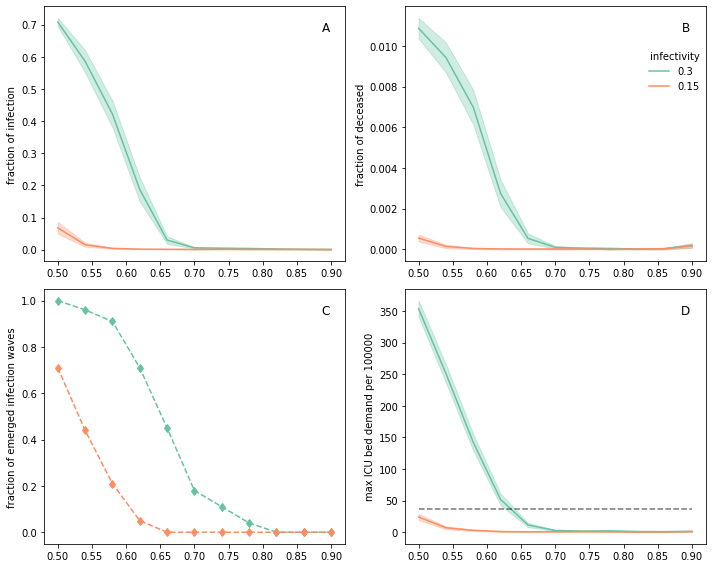

In [97]:
group_folders = group_folders_interaction#['recover_random_scan_0.5_0.9', 'recover_fromWorld_scan_0.5_0.9', 'recover_ordered1_0.5_0.9', 'recover_interaction_scan_0.5_0.9'] 
legend_lables =['0.3','0.15']#,'random']
#legend_lables = ['random','previous infection spreading','ordered 1', 'interactions']
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
cutoff=30

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8))
#plt.suptitle(group_folders[0].split('_')[1])

for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[99]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,color=defaultCmap(k))
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3,color=defaultCmap(k))
    axes[0][0].set_ylabel('fraction of infection') 
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()

    CI = confi_z_dict[99]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m, color=defaultCmap(k))
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI,df_D_m.values+CI, alpha=0.3, color=defaultCmap(k))
    axes[0][1].set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=group_folders[k].split('_')[1], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    axes[1][1].plot(df_ICU_m, color=defaultCmap(k))
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU, alpha=0.3, color=defaultCmap(k))
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.5,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')


# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-15, -15), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top')    
    
plt.tight_layout()

axes[0][1].legend(legend_lables, markerscale=1,
                  frameon=False, loc=(0.8,0.65),
                  ncol=1,#len(legend_lables),
                  title = 'infectivity')


plt.savefig('plots/fig_recover_test_scans', bbox_inches='tight') 
plt.savefig('plots/fig_recover_test_scans.svg', bbox_inches='tight') 

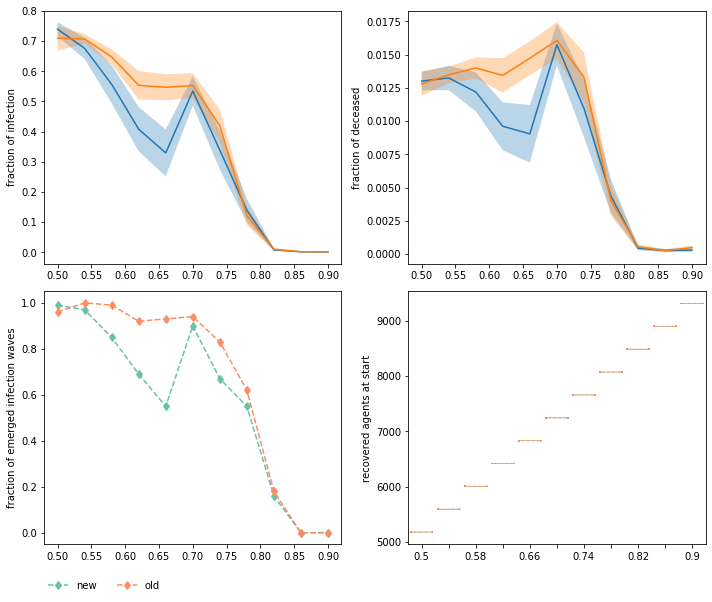

In [98]:
group_folders = group_folders_ordered#['recover_random_scan_0.5_0.9', 'recover_fromWorld_scan_0.5_0.9', 'recover_ordered1_0.5_0.9', 'recover_interaction_scan_0.5_0.9'] 
legend_lables =['new','old']
#legend_lables = ['random','previous infection spreading','ordered 1', 'interactions']
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
cutoff=30

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8))
#plt.suptitle(group_folders[0].split('_')[1])
for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[99]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,)
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3)
    axes[0][0].set_ylabel('fraction of infection') 
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()

    CI = confi_z_dict[99]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m)
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI,df_D_m.values+CI, alpha=0.3)
    axes[0][1].set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=group_folders[k].split('_')[1], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    
    #control recoverd agents
    sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    axes[1][1].set_ylabel('recovered agents at start')

    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)


# Caption Numbering
#axes[0][0].text(0.87,0.78,'A', fontsize=12)
#axes[0][1].text(0.87,0.016,'B', fontsize=12)
#axes[1][0].text(0.85,0.9,'C', fontsize=12)
#axes[1][1].text(0.5,9000,'D', fontsize=12)
    
    
plt.tight_layout()

axes[1][0].legend(legend_lables, markerscale=1, frameon=False, loc=(0,-0.2), ncol=len(legend_lables))


plt.savefig('plots/fig_recover_scans', bbox_inches='tight') 
plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

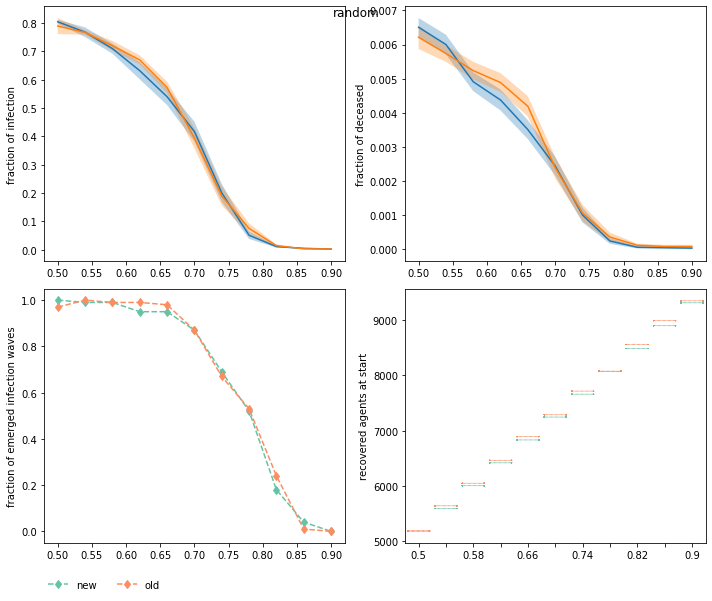

In [99]:
group_folders = group_folders_random#['recover_random_scan_0.5_0.9', 'recover_fromWorld_scan_0.5_0.9', 'recover_ordered1_0.5_0.9', 'recover_interaction_scan_0.5_0.9'] 
legend_lables =['new','old']
#legend_lables = ['random','previous infection spreading','ordered 1', 'interactions']
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
cutoff=30

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8))
plt.suptitle(group_folders[0].split('_')[1])
for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,)
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3)
    axes[0][0].set_ylabel('fraction of infection') 
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()

    CI = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m)
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI,df_D_m.values+CI, alpha=0.3)
    axes[0][1].set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=group_folders[k].split('_')[1], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    
    #control recoverd agents
    sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    axes[1][1].set_ylabel('recovered agents at start')

    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)


# Caption Numbering
#axes[0][0].text(0.87,0.78,'A', fontsize=12)
#axes[0][1].text(0.87,0.016,'B', fontsize=12)
#axes[1][0].text(0.85,0.9,'C', fontsize=12)
#axes[1][1].text(0.5,9000,'D', fontsize=12)
    
    
plt.tight_layout()

axes[1][0].legend(legend_lables, markerscale=1, frameon=False, loc=(0,-0.2), ncol=len(legend_lables))


plt.savefig('plots/fig_recover_scans', bbox_inches='tight') 
plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

<a id='mainP'></a>
### Main Plot

### inf 0.3

In [100]:
deceased_data_dict = {}

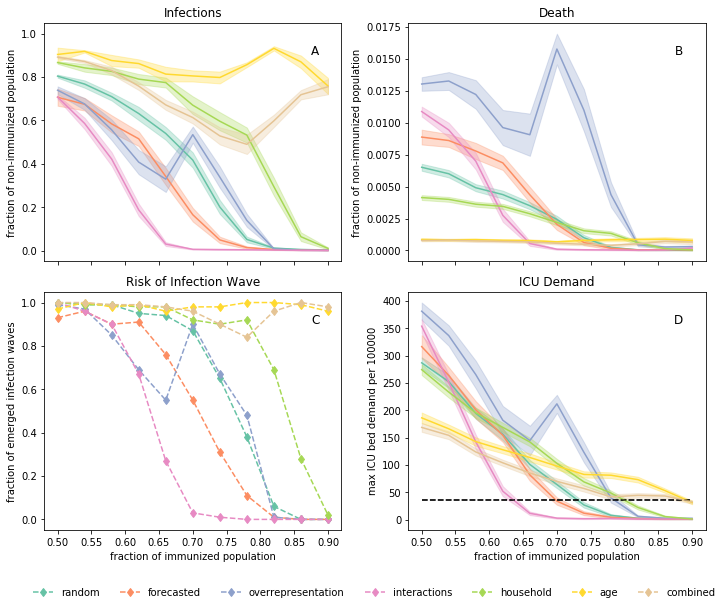

In [101]:
group_folders = ['recover_random_scan_0.5_0.9',
                 'recover_from_world_scan_0.5_0.9', 
                 'recover_ordered1_scan_0.5_0.9', 
                 'recover_interaction_scan_0.5_0.9',
                 'recover_household_scan_0.5_0.9',
                 'recover_age_scan_0.5_0.9',
                 'recover_mix1_scan_0.5_0.9'] 

legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5: ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7: ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9: ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    legend_lables.append(f.split('_')[1])
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)
#fig2, axes2 = plt.subplots(1,2,figsize=(10,4))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,color=defaultCmap(k))
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3, color=defaultCmap(k))
    axes[0][0].set_ylabel('fraction of non-immunized population') 
    axes[0][0].set_ylim(-0.05,1.05)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
    ### save data
    deceased_data_dict[label_dict[legend_lables[k]]] = df_D_m
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m, color=defaultCmap(k))
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D, alpha=0.3, color=defaultCmap(k))
    axes[0][1].set_ylabel('fraction of non-immunized population')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    axes[1][0].set_ylim(-0.05,1.05)
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[1][1].plot(df_ICU_m, color=defaultCmap(k))
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU, alpha=0.3, color=defaultCmap(k))
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.5,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')
    
    #pareto front??
    #axes2[0].plot(1-df_I/100,-df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    #axes2[0].set_title('fraction of non waves vs death')
    #axes2[1].plot(-df_m, -df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    
    
    for x in pareto_dict:
        pareto_dict[x][0].append(1-df_I[x]/100)
        pareto_dict[x][1].append(df_D_m[x])
    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-22, -22), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top') 
# xlabel
xlabel = 'fraction of immunized population'#'fraction of initial non-susceptible persons' 
axes[1][0].set_xlabel(xlabel)
axes[1][1].set_xlabel(xlabel)

#titles
axes[0][0].set_title('Infections')
axes[0][1].set_title('Death')
axes[1][0].set_title('Risk of Infection Wave')
axes[1][1].set_title('ICU Demand')

fig.tight_layout()
axes[1][0].legend( markerscale=1, frameon=False, loc=(-0.05,-0.3), ncol=len(legend_lables))

#plt.savefig('plots/fig_recover_scans.png', bbox_inches='tight') 
#plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

###  0.15 vs 0.3

In [102]:
legend_lables

['random', 'from', 'ordered1', 'interaction', 'household', 'age', 'mix1']

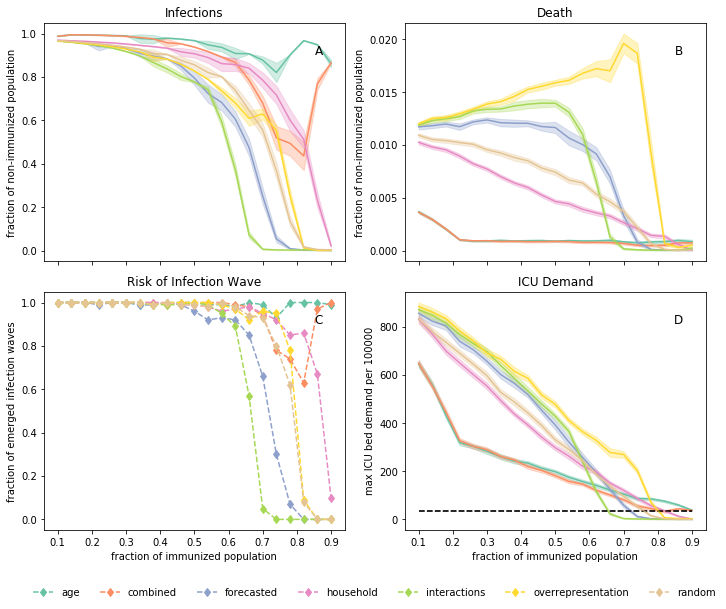

In [103]:
group_folders = ['fixed_recover_age_scan_0.1_0.9',
                 'fixed_recover_ageinteractions_scan_0.1_0.9',
                 'fixed_recover_from_world_scan_0.1_0.9',
                 'fixed_recover_household_scan_0.1_0.9',
                 'fixed_recover_interactions_scan_0.1_0.9',
                 'fixed_recover_overrepresentation_scan_0.1_0.9',
                 'fixed_recover_random_scan_0.1_0.9'] 

legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5: ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7: ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9: ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    legend_lables.append(f.split('_')[2])
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)
#fig2, axes2 = plt.subplots(1,2,figsize=(10,4))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,color=defaultCmap(k))
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3, color=defaultCmap(k))
    axes[0][0].set_ylabel('fraction of non-immunized population') 
    axes[0][0].set_ylim(-0.05,1.05)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
    ### save data
    deceased_data_dict[label_dict[legend_lables[k]]] = df_D_m
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m, color=defaultCmap(k))
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D, alpha=0.3, color=defaultCmap(k))
    axes[0][1].set_ylabel('fraction of non-immunized population')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    axes[1][0].set_ylim(-0.05,1.05)
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[1][1].plot(df_ICU_m, color=defaultCmap(k))
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU, alpha=0.3, color=defaultCmap(k))
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.1,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')
    
    #pareto front??
    #axes2[0].plot(1-df_I/100,-df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    #axes2[0].set_title('fraction of non waves vs death')
    #axes2[1].plot(-df_m, -df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    
    
    for x in pareto_dict:
        pareto_dict[x][0].append(1-df_I[x]/100)
        pareto_dict[x][1].append(df_D_m[x])
    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-22, -22), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top') 
# xlabel
xlabel = 'fraction of immunized population'#'fraction of initial non-susceptible persons' 
axes[1][0].set_xlabel(xlabel)
axes[1][1].set_xlabel(xlabel)

#titles
axes[0][0].set_title('Infections')
axes[0][1].set_title('Death')
axes[1][0].set_title('Risk of Infection Wave')
axes[1][1].set_title('ICU Demand')

fig.tight_layout()
axes[1][0].legend( markerscale=1, frameon=False, loc=(-0.05,-0.3), ncol=len(legend_lables))

#plt.savefig('plots/fig_recover_scans.png', bbox_inches='tight') 
#plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

<a id='01sus'></a>
###  10% of vaccinated suceptible to infection
[back to top](#main)

In [104]:
legend_lables

['age',
 'ageinteractions',
 'from',
 'household',
 'interactions',
 'overrepresentation',
 'random']

In [105]:
label_dict = {'random':['random', defaultCmap(0)], #change labels here 
              'from':['forecasted', defaultCmap(1)], 
              'ordered1':['overrepresentation', defaultCmap(2)],#'set I', 
              'interaction':['interactions', defaultCmap(3)],
              'interactions':['interactions', defaultCmap(3)],
              'household':['household', defaultCmap(4)],
              'age':['age', defaultCmap(5)],
              'mix1':['combined', defaultCmap(6)],#'set II',
              'pensioner': ['pensioner', defaultCmap(7)],
              'ageinteractions': ['combined', defaultCmap(8)],
              'overrepresentation' : ['overrepresentation', defaultCmap(9)]}
alpha_dict = {'scan':1, 'sus':0.5}
deceased_data_dict = {}

In [106]:
print(label_dict[legend_lables[k].split('_')[0]][0])
print(sus)
df_S_list


random
sus


[    0.10  0.14  0.18  0.22  0.26  0.30  0.34  0.38  0.42  0.46  ...  0.54  \
 0   9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 1   9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 2   9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 3   9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 4   9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 ..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
 95  9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 96  9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 97  9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 98  9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 99  9433  9014  8594  8175  7755  7336  6917  6497  6078  5658  ...  4820   
 
     0.58  0.62  0.66  0.70  0.74  0.78  0.82  0.86  0.90  
 0

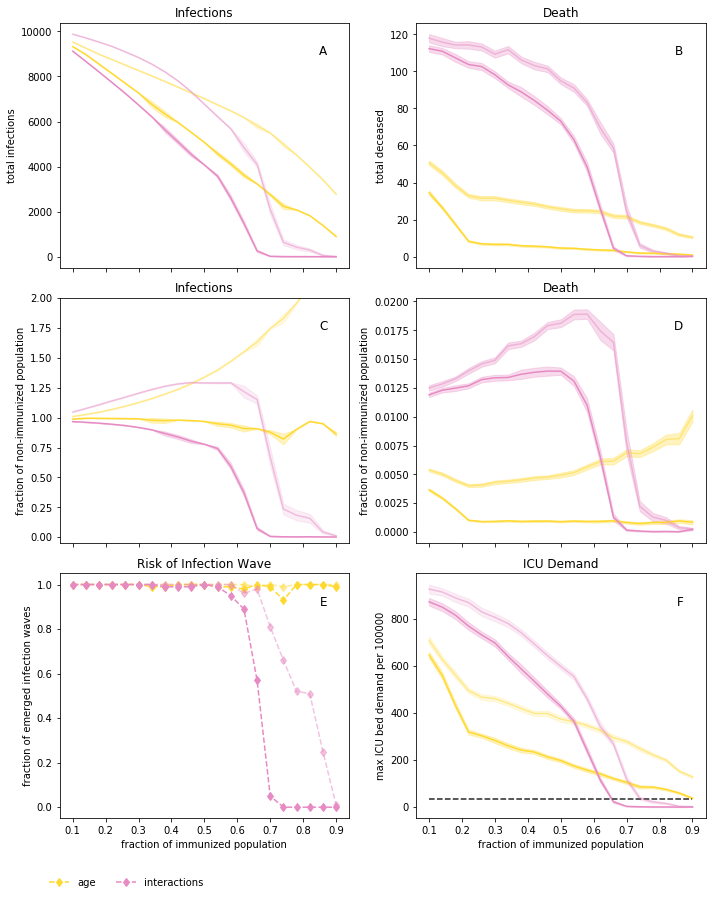

In [107]:
group_folders = ['fixed_recover_age_scan_0.1_0.9',
                 'fixed_recover_age_scan_part_imnty_0.1_sus_0.1_0.9',
                 'fixed_recover_interactions_scan_0.1_0.9',
                 'fixed_recover_interactions_scan_part_imnty_0.1_sus_0.1_0.9',] 



legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5:  ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7:  ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9:  ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    legend_lables.append(f.split('_')[2]+'_'+f.split('_')[-3])
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(3,2,figsize=(10,12), sharex=True)
#fig2, axes2 = plt.subplots(1,2,figsize=(10,4))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    sus = legend_lables[k].split('_')[1]
    if sus == 'scan':
        label = label_dict[legend_lables[k].split('_')[0]][0]
    else:
        label = ''
    color = label_dict[legend_lables[k].split('_')[0]][1]
    alpha = alpha_dict[sus]
    
    
    df_S = df_S_list[0] #achtunG !!!!!!!!
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I#/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))
    
    ##
    axes[0][0].plot(df_m.index,df_m.values,
                    color=color,
                    alpha=alpha)
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI,
                            alpha=0.3*alpha,
                            color=color)
    axes[0][0].set_ylabel('total infections')  #total infections
    #axes[0][0].set_ylim(-0.05,2.0)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]#/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
    ### save data
    #deceased_data_dict[label_dict[legend_lables[k]]] = df_D_m
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m, color=color, alpha=alpha)
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D, df_D_m.values+CI_D,
                            alpha=0.3,
                            color=color)
    axes[0][1].set_ylabel('total deceased')
    ticks= axes[0][1].get_yticks()
    ##
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))
    
    axes[1][0].plot(df_m.index,df_m.values,
                    color=color,
                    alpha=alpha)
    axes[1][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI,
                            alpha=0.3*alpha,
                            color=color)
    axes[1][0].set_ylabel('fraction of non-immunized population')  #total infections
    axes[1][0].set_ylim(-0.05,2.0)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
    ### save data
    #deceased_data_dict[label_dict[legend_lables[k]]] = df_D_m
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[1][1].plot(df_D_m, color=color, alpha=alpha)
    axes[1][1].fill_between(df_D_m.index,df_D_m.values-CI_D, df_D_m.values+CI_D,
                            alpha=0.3,
                            color=color)
    axes[1][1].set_ylabel('fraction of non-immunized population')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[2][0].plot(df_I/100 ,'--d',
                    label=label,
                    color=color,
                    alpha=alpha)
    axes[2][0].set_ylabel('fraction of emerged infection waves')
    axes[2][0].set_ylim(-0.05,1.05)
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[2][1].plot(df_ICU_m, color=color, alpha=alpha)
    axes[2][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU,
                            alpha=alpha*0.3,
                            color=color)
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[2][1].plot(np.linspace(0.1,0.9,10),[ICU_cap_per_100000]*10,'--k',
                    alpha=0.3)
    axes[2][1].set_ylabel('max ICU bed demand per 100000')
    
    #pareto front??
    #axes2[0].plot(1-df_I/100,-df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    #axes2[0].set_title('fraction of non waves vs death')
    #axes2[1].plot(-df_m, -df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    
    
    for x in pareto_dict:
        pareto_dict[x][0].append(1-df_I[x]/100)
        pareto_dict[x][1].append(df_D_m[x])
    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D','E','F',]
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-22, -22), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top') 
# xlabel
xlabel = 'fraction of immunized population'#'fraction of initial non-susceptible persons' 
axes[2][0].set_xlabel(xlabel)
axes[2][1].set_xlabel(xlabel)

#titles
axes[0][0].set_title('Infections')
axes[0][1].set_title('Death')
axes[1][0].set_title('Infections')
axes[1][1].set_title('Death')
axes[2][0].set_title('Risk of Infection Wave')
axes[2][1].set_title('ICU Demand')

fig.tight_layout()
axes[2][0].legend( markerscale=1, frameon=False, loc=(-0.05,-0.3), ncol=len(legend_lables))

plt.savefig('plots/fig_recover_scans_01sus.png', bbox_inches='tight') 
plt.savefig('plots/fig_recover_scans_01sus.svg', bbox_inches='tight') 

### test old vs fixed

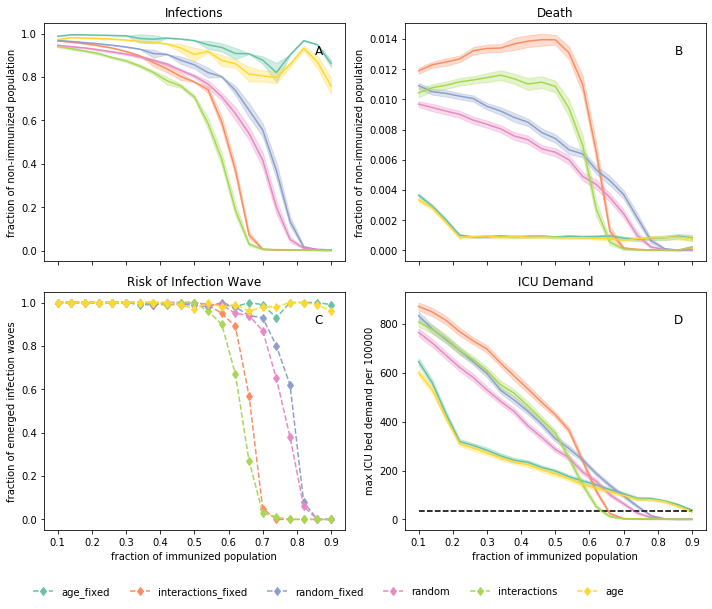

In [108]:
group_folders = ['fixed_recover_age_scan_0.1_0.9',
                 'fixed_recover_interactions_scan_0.1_0.9',
                 'fixed_recover_random_scan_0.1_0.9',
                 'recover_random_scan_0.1_0.9',
                 'recover_interactions_scan_0.1_0.9',
                 'recover_age_scan_0.1_0.9',
                ] 

legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5: ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7: ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9: ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    if f.split('_')[0]=='fixed':
        legend_lables.append(f.split('_')[2]+'_fixed')
    elif f.split('_')[0]=='recover' :
        legend_lables.append(f.split('_')[1])
    else:
        break
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)
#fig2, axes2 = plt.subplots(1,2,figsize=(10,4))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,color=defaultCmap(k))
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3, color=defaultCmap(k))
    axes[0][0].set_ylabel('fraction of non-immunized population') 
    axes[0][0].set_ylim(-0.05,1.05)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
    ### save data
    #deceased_data_dict[label_dict[legend_lables[k]]] = df_D_m
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m, color=defaultCmap(k))
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D, alpha=0.3, color=defaultCmap(k))
    axes[0][1].set_ylabel('fraction of non-immunized population')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=legend_lables[k], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    axes[1][0].set_ylim(-0.05,1.05)
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[1][1].plot(df_ICU_m, color=defaultCmap(k))
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU, alpha=0.3, color=defaultCmap(k))
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.1,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')
    
    #pareto front??
    #axes2[0].plot(1-df_I/100,-df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    #axes2[0].set_title('fraction of non waves vs death')
    #axes2[1].plot(-df_m, -df_D_m.values, '--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    
    
    for x in pareto_dict:
        pareto_dict[x][0].append(1-df_I[x]/100)
        pareto_dict[x][1].append(df_D_m[x])
    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-22, -22), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top') 
# xlabel
xlabel = 'fraction of immunized population'#'fraction of initial non-susceptible persons' 
axes[1][0].set_xlabel(xlabel)
axes[1][1].set_xlabel(xlabel)

#titles
axes[0][0].set_title('Infections')
axes[0][1].set_title('Death')
axes[1][0].set_title('Risk of Infection Wave')
axes[1][1].set_title('ICU Demand')

fig.tight_layout()
axes[1][0].legend( markerscale=1, frameon=False, loc=(-0.05,-0.3), ncol=len(legend_lables))

plt.savefig('plots/fig_recover_scans.png', bbox_inches='tight') 
plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

<a id='inf0.15'></a>
### inf 0.15 vs inf 0.3

In [109]:
label_dict = {'random':['random', defaultCmap(0)], #change labels here 
                'from':['forecasted', defaultCmap(1)], 
                'ordered1':['overrepresentation', defaultCmap(2)],#'set I', 
                'interaction':['interactions', defaultCmap(3)],
                'interactions':['interactions', defaultCmap(3)],
                'household':['household', defaultCmap(4)],
                'age':['age', defaultCmap(5)],
                'mix1':['combined', defaultCmap(6)],#'set II',
                'pensioner': ['pensioner', defaultCmap(7)],
                'ageinteractions': ['combined', defaultCmap(8)],
                'overrepresentation' : ['overrepresentation', defaultCmap(9)]}
alpha_dict = {0.30:1, 0.15:0.5}

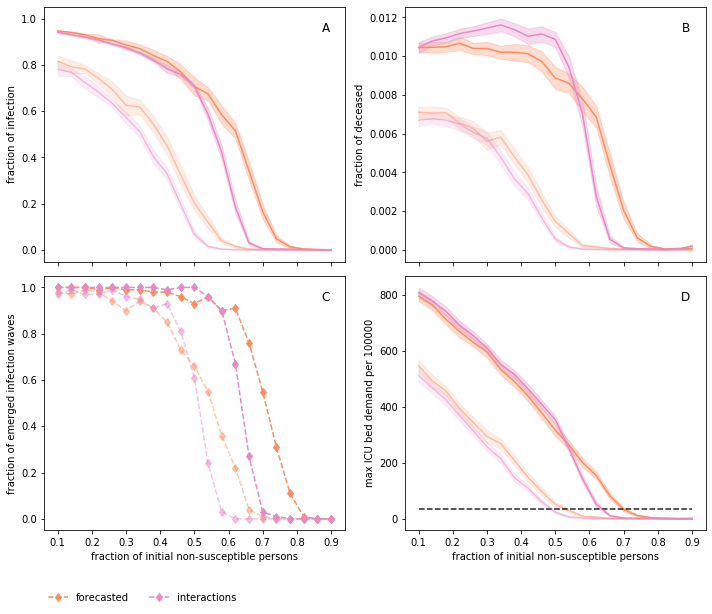

In [110]:
group_folders = ['recover_from_world_scan_0.1_0.9_inf_0.15',
                 'recover_from_world_scan_0.1_0.9_inf_0.30', 
                 'recover_interactions_scan_0.1_0.9_inf_0.15',
                 'recover_interactions_scan_0.1_0.9_inf_0.30',
                ]

legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5: ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7: ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9: ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    legend_lables.append(f.split('_')[1]+'_'+f.split('_')[-1])
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)
#fig2, axes2 = plt.subplots(1,2,figsize=(10,4))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    inf = float(legend_lables[k].split('_')[1])
    if inf == 0.30:
        label = label_dict[legend_lables[k].split('_')[0]][0]
    else:
        label = ''
    color = label_dict[legend_lables[k].split('_')[0]][1]
    alpha = alpha_dict[inf]
    
    
    df_S = df_S_list[k]
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,
                    color = color,
                    alpha = alpha)
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI,
                            color = color,
                            alpha = alpha*0.3)
    axes[0][0].set_ylabel('fraction of infection') 
    axes[0][0].set_ylim(-0.05,1.05)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m,
                    color = color,
                    alpha = alpha)
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D,
                    color = color,
                    alpha = alpha*0.3)
    
    axes[0][1].set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', 
                    label=label,
                    color = color,
                    alpha = alpha)
    
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    axes[1][0].set_ylim(-0.05,1.05)
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[1][1].plot(df_ICU_m, 
                    color = color,
                    alpha = alpha)
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU,
                            color = color,
                            alpha = alpha*0.3)    
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.1,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')

    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-15, -15), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top') 
# xlabel
axes[1][0].set_xlabel('fraction of initial non-susceptible persons')
axes[1][1].set_xlabel('fraction of initial non-susceptible persons')

fig.tight_layout()
axes[1][0].legend(markerscale=1, frameon=False, loc=(0,-0.3), ncol=len(legend_lables))

plt.savefig('plots/fig_recover_scans_inf.png', bbox_inches='tight') 
plt.savefig('plots/fig_recover_scans_inf.svg', bbox_inches='tight') 

In [111]:
nr_agents_list[k]

10351

<a id='1dose'></a>
### 1 Dose vs 2 Doses 

In [112]:
label_dict = {'random':['random', defaultCmap(0)], #change labels here 
                'from':['forecasted', defaultCmap(1)], 
                'ordered1':['overrepresentation', defaultCmap(2)],#'set I', 
                'interaction':['interactions', defaultCmap(3)],
                'interactions':['interactions', defaultCmap(3)],
                'household':['household', defaultCmap(4)],
                'age':['age', defaultCmap(5)],
                'mix1':['combined', defaultCmap(6)],#'set II',
                'pensioner': ['pensioner', defaultCmap(7)],
                'ageinteractions': ['combined', defaultCmap(8)],
                'overrepresentation' : ['overrepresentation', defaultCmap(9)]}
alpha_dict = {'scan':[1,defaultCmap1(0), '2 Doses'], 'sus': [1, defaultCmap1(1), '1 Dose'], 'inf': [1, defaultCmap1(2)]}

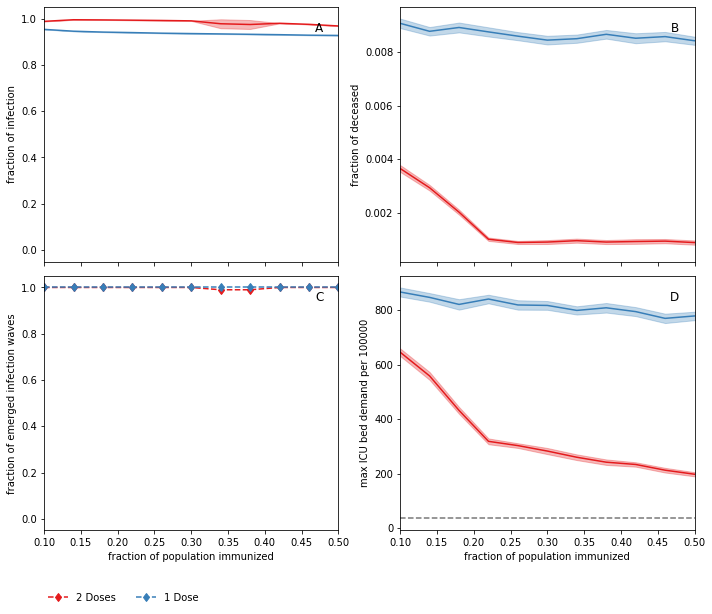

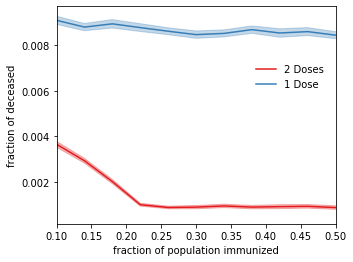

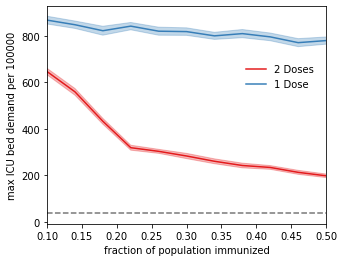

In [113]:
group_folders = ['fixed_recover_age_scan_0.1_0.9',
                 'fixed_recover_age_scan_part_imnty_sus_0.1_0.9',] 
                 #'fixed_recover_age_scan_part_imnty_inf_0.1_0.9',]

legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5: ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7: ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9: ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    legend_lables.append(f.split('_')[2]+'_'+f.split('_')[-3])
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)
fig1, ax1 = plt.subplots(1,1, figsize=(5,4))
fig2, ax2 = plt.subplots(1,1, figsize=(5,4))
#fig2, axes2 = plt.subplots(1,2,figsize=(10,4))

for k,df_delta_I in enumerate(df_delta_I_list):
    
    dose_type = legend_lables[k].split('_')[-1]
    if inf == 0.30:
        label = dose_type #label_dict[legend_lables[k].split('_')[0]][0]
    else:
        label = ''
    color = alpha_dict[dose_type][1]#label_dict[legend_lables[k].split('_')[0]][1]
    alpha = alpha_dict[dose_type][0]
    label = alpha_dict[dose_type][2]
    
    df_S = df_S_list[k]
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,
                    color = color,
                    alpha = alpha)
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI,
                            color = color,
                            alpha = alpha*0.3)
    axes[0][0].set_ylabel('fraction of infection') 
    axes[0][0].set_ylim(-0.05,1.05)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m,
                    color = color,
                    alpha = alpha)
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D,
                    color = color,
                    alpha = alpha*0.3)
    
    axes[0][1].set_ylabel('fraction of deceased')
    #seperate fig
    ax1.plot(df_D_m,
            color = color,
            alpha = alpha,
            label = label)
    ax1.fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D,
                    color = color,
                    alpha = alpha*0.3)
    
    ax1.set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', 
                    label = label,
                    color = color,
                    alpha = alpha)
    
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    axes[1][0].set_ylim(-0.05,1.05)
    
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[1][1].plot(df_ICU_m, 
                    color = color,
                    alpha = alpha)
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU,
                            color = color,
                            alpha = alpha*0.3)    
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.1,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')
    #seperate fig 
    ax2.plot(df_ICU_m, 
             color = color,
             alpha = alpha,
             label = label)
    ax2.fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU,
                            color = color,
                            alpha = alpha*0.3)    
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    ax2.plot(np.linspace(0.1,0.9,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    ax2.set_ylabel('max ICU bed demand per 100000')
    

    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-15, -15), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top')
    ax.set_xlim(0.1,0.5)
# xlabel
axes[1][0].set_xlabel('fraction of population immunized')
axes[1][1].set_xlabel('fraction of population immunized')
ax1.set_xlabel('fraction of population immunized')
ax2.set_xlabel('fraction of population immunized')

ax1.set_xlim(0.1,0.5)
ax2.set_xlim(0.1,0.5)

fig.tight_layout()
axes[1][0].legend(markerscale=1, frameon=False, loc=(0,-0.3), ncol=len(legend_lables))
ax1.legend(markerscale=1, frameon=False, loc=(0.7,0.6),)
ax2.legend(markerscale=1, frameon=False, loc=(0.7,0.6),)
fig.savefig('plots/fig_recover_scans_doses.png', bbox_inches='tight') 
fig.savefig('plots/fig_recover_scans_doses.svg', bbox_inches='tight') 
fig1.savefig('plots/fig_recover_scans_doses_deceased.png',dpi=300,  bbox_inches='tight') 
fig1.savefig('plots/fig_recover_scans_doses_deceased.svg', bbox_inches='tight') 
fig2.savefig('plots/fig_recover_scans_doses_icu.png', dpi=300, bbox_inches='tight') 
fig2.savefig('plots/fig_recover_scans_doses_icu.svg', bbox_inches='tight') 


<a id='test'></a>
### Test new stuff

In [114]:
recover_list = [x for x in scenarios_list if x.startswith('recover_')]
recover_list_long =[x for x in recover_list if '0.1' in x.split('_')]
recover_list_long

['recover_age_scan_0.1_0.9',
 'recover_from_world_scan_0.1_0.9',
 'recover_from_world_scan_0.1_0.9_inf_0.15',
 'recover_from_world_scan_0.1_0.9_inf_0.30',
 'recover_household_scan_0.1_0.9',
 'recover_household_scan_0.1_0.9_inf_0.15',
 'recover_interactions_scan_0.1_0.9',
 'recover_interactions_scan_0.1_0.9_inf_0.15',
 'recover_interactions_scan_0.1_0.9_inf_0.30',
 'recover_mix1_scan_0.1_0.9',
 'recover_ordered1_scan_0.1_0.9',
 'recover_random_scan_0.1_0.9',
 'recover_random_scan_0.1_0.9_inf_0.15']

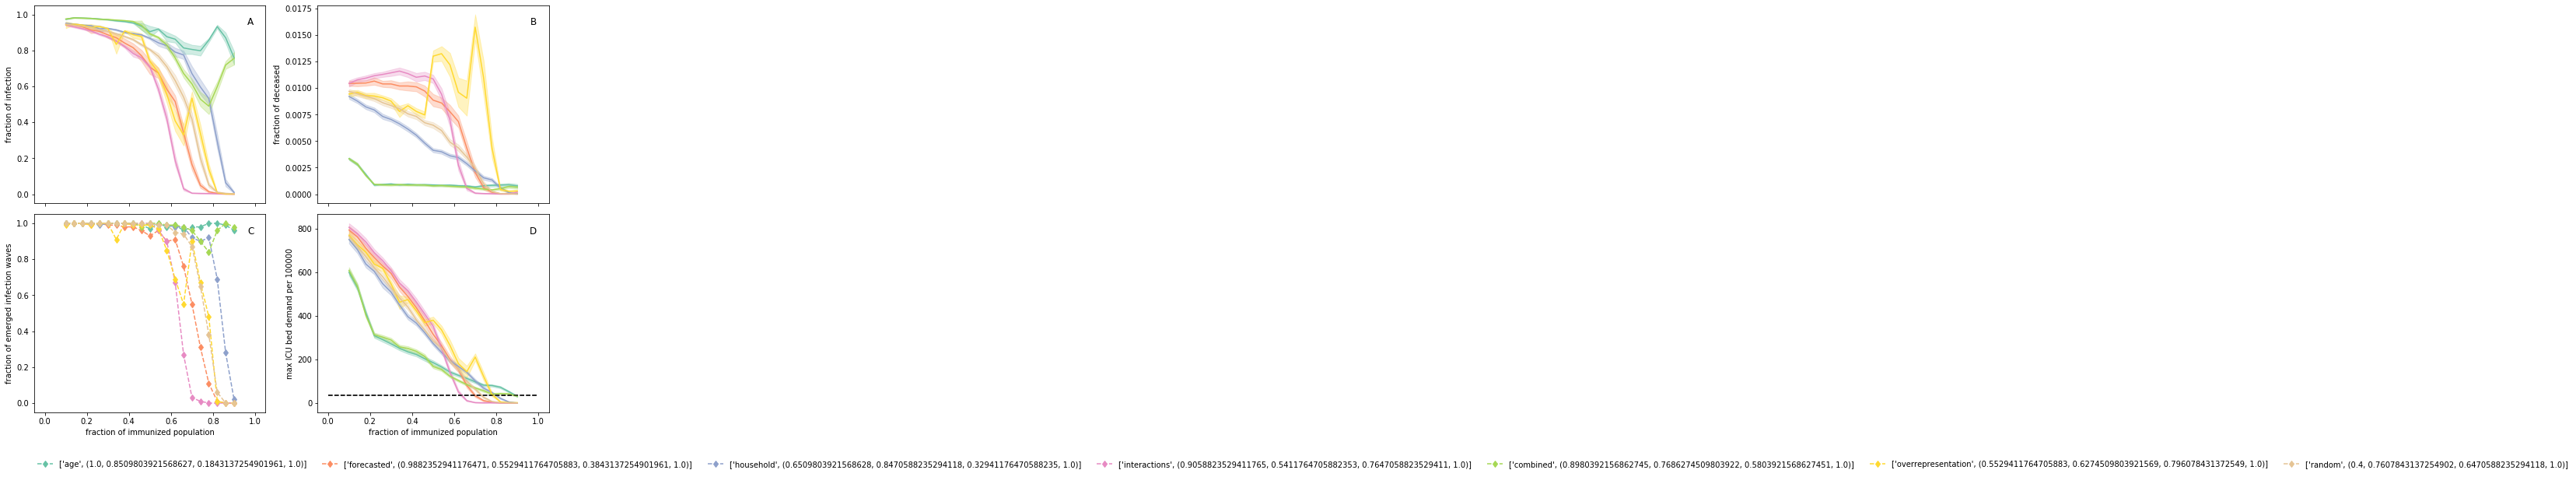

In [124]:
recover_list_long_inf03 = [x for x in recover_list_long if 'inf' not in x.split('_')]
group_folders = recover_list_long_inf03#['recover_age_scan_0.1_0.9']#,'recover_interactions_scan_0.1_0.9_inf_0.15']
##!!!!!!!! different infectivities!!!!

legend_lables = []
df_delta_I_list = []
df_R_list = []
df_S_list = []
df_I_list = []
df_D_list = []
df_ICU_list = []
nr_agents_list = []
pareto_dict = {0.5: ([], []),
               0.54: ([], []),
               0.58: ([], []),
               0.62: ([], []),
               0.66: ([], []),
               0.7: ([], []),
               0.74: ([], []),
               0.78: ([], []),
               0.82: ([], []),
               0.86: ([], []),
               0.9: ([], [])}

cutoff=80

for f in group_folders:
    data_folder = server_data_folder_str+f +'/'
    subfolder = [x for x in os.listdir(data_folder) if not x.endswith('csv')]
    subfolder.sort()
    df_delta_I_list.append(get_delta_I(subfolder, data_folder,status='I', digits=7))
    df_R_list.append(get_df_total_status(subfolder, data_folder, status='R', digits=7, time_loc=1))
    df_S_list.append(get_df_total_status(subfolder, data_folder, status='S', digits=7, time_loc=1))
    df_I_list.append(get_df_total_status(subfolder, data_folder, status='I', digits=7, time_loc=1))
    df_D_list.append(get_df_total_status(subfolder, data_folder, status='D', digits=7, time_loc=-1)) #end
    df_ICU_list.append(get_df_max_status(subfolder, data_folder, status='ICUed', digits=7))
    nr_agents_list.append(get_nr_of_agents(subfolder[0], data_folder))
    legend_lables.append(f.split('_')[1])
col = list(df_delta_I_list[0].keys())
col.sort()

fig, axes = plt.subplots(2,2,figsize=(10,8), sharex=True)

for k,df_delta_I in enumerate(df_delta_I_list):
    
    df_S = df_S_list[k]
    df_ICU = df_ICU_list[k]
    ## infected fraction
    df_I_ratio = df_delta_I/df_S
    df_std = df_I_ratio.std()
    df_m = df_I_ratio.mean()
    CI = confi_z_dict[95]*df_std.values/np.sqrt(len(df_I_ratio))

    axes[0][0].plot(df_m.index,df_m.values,color=defaultCmap(k))
    axes[0][0].fill_between(df_m.index,df_m.values-CI,df_m.values+CI, alpha=0.3, color=defaultCmap(k))
    axes[0][0].set_ylabel('fraction of infection') 
    axes[0][0].set_ylim(-0.05,1.05)
    
    # fraction of dead
    df_D_ratio = df_D_list[k]/df_S
    df_D_m = df_D_ratio.mean()
    df_D_std = df_D_ratio.std()
    ### save data
    #deceased_data_dict[label_dict[legend_lables[k]]] = df_D_m
        
    CI_D = confi_z_dict[95]*df_D_std.values/np.sqrt(len(df_D_ratio))
    axes[0][1].plot(df_D_m, color=defaultCmap(k))
    axes[0][1].fill_between(df_D_m.index,df_D_m.values-CI_D,df_D_m.values+CI_D, alpha=0.3, color=defaultCmap(k))
    axes[0][1].set_ylabel('fraction of deceased')
    ticks= axes[0][1].get_yticks()
    
    # apperance of second wave /fraction
    df_I_new=df_delta_I[df_delta_I>cutoff]
    df_I = df_I_new.count().sort_index()
    
    axes[1][0].plot(df_I/100 ,'--d', label=label_dict[legend_lables[k]], color=defaultCmap(k))
    axes[1][0].set_ylabel('fraction of emerged infection waves')
    axes[1][0].set_ylim(-0.05,1.05)
    #ICU
    df_ICU_ratio = df_ICU_list[k]/nr_agents_list[k]*100000
    df_ICU_m = df_ICU_ratio.mean(axis=0)
    df_ICU_std = df_ICU_ratio.std(axis=0)
    CI_ICU = confi_z_dict[95]*df_ICU_std.values/np.sqrt(len(df_ICU_ratio))
    #control recoverd agents
    #sns.swarmplot(data = df_R_list[k][col], color=defaultCmap(k), size=1, ax=axes[1][1], label= 'random_recovery')
    #axes[1][1].set_xticklabels([x if col.index(x)%2==0 else None for x in col])
    #axes[1][1].set_ylabel('recovered agents at start')
    axes[1][1].plot(df_ICU_m, color=defaultCmap(k))
    axes[1][1].fill_between(df_ICU_m.index,df_ICU_m.values-CI_ICU,df_ICU_m.values+CI_ICU, alpha=0.3, color=defaultCmap(k))
    #axes[1].legend(markerscale=1, frameon=False, loc=(-0.8,-0.2), ncol=3)
    axes[1][1].plot(np.linspace(0.0,1.0,10),[ICU_cap_per_100000]*10,'--k', alpha=0.3)
    axes[1][1].set_ylabel('max ICU bed demand per 100000')
    
    for x in pareto_dict:
        pareto_dict[x][0].append(1-df_I[x]/100)
        pareto_dict[x][1].append(df_D_m[x])
    
# Caption Numbering
axes.flatten()
ax_labels=['A','B','C','D']
for i,ax in enumerate(axes.flatten()):
    ax.annotate(ax_labels[i], xy=(1, 1), xytext=(-15, -15), fontsize=12,
                    xycoords='axes fraction', textcoords='offset points',
                    horizontalalignment='right', verticalalignment='top') 
# xlabel
xlabel = 'fraction of immunized population'#'fraction of initial non-susceptible persons' 
axes[1][0].set_xlabel(xlabel)
axes[1][1].set_xlabel(xlabel)

fig.tight_layout()
axes[1][0].legend( markerscale=1, frameon=False, loc=(0,-0.3), ncol=len(legend_lables))

#plt.savefig('plots/fig_recover_scans.png', dpi=300, bbox_inches='tight') 
#plt.savefig('plots/fig_recover_scans.svg', bbox_inches='tight') 

<a id='perfomance'></a>
### Performance

In [116]:
fractions = np.linspace(0.5,0.9,100)

In [117]:
interpolated_data_dict = {x: np.interp(fractions, deceased_data_dict[x].index, deceased_data_dict[x].values) for x in deceased_data_dict}

In [118]:
interpolated_data_df = pd.DataFrame(interpolated_data_dict, index=fractions)
interpolated_data_df.columns

Index([], dtype='object')

In [119]:
x_crossing_dict_x = {}
for x in interpolated_data_df.columns:
    x_crossing_dict_y = {}
    for y in interpolated_data_df.columns:
        try:
            x_crossing = interpolated_data_df[interpolated_data_df[x]>=interpolated_data_df[y]].index[0]
        except IndexError:
            x_crossing = 1.0
        if x == y:
            x_crossing = 0
        x_crossing_dict_y[y] = x_crossing
    x_crossing_dict_x[x] = x_crossing_dict_y   

In [120]:
l = list(interpolated_data_df.columns)
l.reverse()
l

[]

In [121]:
x_crossing_direction_dict_x = {}
x_crossing_dict_x = {}


for x in interpolated_data_df.columns:
    x_crossing_dict_y = {}
    x_crossing_direction_dict_y = {}
    for y in interpolated_data_df.columns:
        direction=0
        
        try:
            x_crossing_1 = interpolated_data_df[interpolated_data_df[x]>=interpolated_data_df[y]].index[0]
        except IndexError:
            x_crossing_1 = 1.0
        
        try:
            x_crossing_2 = interpolated_data_df[interpolated_data_df[x]<=interpolated_data_df[y]].index[0]
        except IndexError:
            x_crossing_2 = 1.0  
            
#            x_crossing_2 = interpolated_data_df[interpolated_data_df[x]<=interpolated_data_df[y]].index[0]

        if x_crossing_1 < x_crossing_2:
            x_crossing = x_crossing_2
            direction= -x_crossing_2
        else:
            x_crossing = x_crossing_1
            direction= x_crossing_1
        

        
        if x == y:
            x_crossing = -1
            direction = 0
        x_crossing_dict_y[y] = x_crossing
        x_crossing_direction_dict_y[y] = direction
    x_crossing_dict_x[x] = x_crossing_dict_y
    x_crossing_direction_dict_x[x] = x_crossing_direction_dict_y

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:280: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:280: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


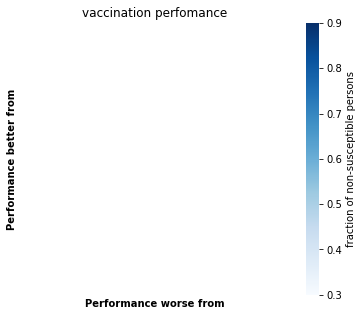

In [122]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

df_crossing = pd.DataFrame(x_crossing_dict_x)
sns.heatmap(df_crossing, cmap="Blues", linewidths=0.5,
            vmin=0.3, vmax=0.9,
            annot=True, cbar_kws={'label': 'fraction of non-susceptible persons'},
            ax=ax)
ax.set_title('vaccination perfomance', )
ax.set_ylabel('Performance better from', fontweight='bold')
ax.set_xlabel('Performance worse from',fontweight='bold')


for p in ax.texts:
    x,y = p.get_position()
    if x==y:
        p.set_text('')
ax.tick_params(axis=u'both', which=u'both',length=0) 
#fig.tight_layout()
plt.savefig('plots/fig_recover_performance.png', bbox_inches='tight') 
plt.savefig('plots/fig_recover_performance.svg', bbox_inches='tight') 

In [267]:
x_crossing_direction_dict_x

{'random': {'random': 0,
  'previous infection wave': 0.6898989898989899,
  'set I': 0.6898989898989899,
  'interactions': 0.6050505050505051,
  'household': -0.7141414141414142,
  'age': -0.7505050505050506,
  'set II': -0.7707070707070707},
 'previous infection wave': {'random': -0.6898989898989899,
  'previous infection wave': 0,
  'set I': 0.5,
  'interactions': 0.5606060606060606,
  'household': -0.6979797979797979,
  'age': -0.7383838383838384,
  'set II': -0.7585858585858586},
 'set I': {'random': -0.7585858585858586,
  'previous infection wave': -0.7585858585858586,
  'set I': 0,
  'interactions': 0.5,
  'household': -0.8191919191919192,
  'age': -0.8191919191919192,
  'set II': -0.8232323232323232},
 'interactions': {'random': -0.6050505050505051,
  'previous infection wave': -0.5606060606060606,
  'set I': 0.5,
  'interactions': 0,
  'household': -0.6131313131313132,
  'age': -0.6575757575757576,
  'set II': -0.6575757575757576},
 'household': {'random': 0.7141414141414142,
 

In [33]:
label = df_crossing.values

In [29]:
cmap = sns.diverging_palette(220, 20, as_cmap=True,n=3)
cmap

['random',
 'forcasted',
 'set I',
 'interactions',
 'household',
 'age',
 'set II',
 'forecasted',
 'overrepresentation',
 'combined']

In [34]:
l=list(interpolated_data_df.columns)
#l.reverse()

x_crossing_direction_dict_x = {}
x_crossing_dict_x = {}


for x in l:
    x_crossing_dict_y = {}
    x_crossing_direction_dict_y = {}
    for y in interpolated_data_df.columns:
        direction=0
        
        try:
            x_crossing_1 = interpolated_data_df[interpolated_data_df[x]>=interpolated_data_df[y]].index[0]
        except IndexError:
            x_crossing_1 = 1.0
        
        try:
            x_crossing_2 = interpolated_data_df[interpolated_data_df[x]<=interpolated_data_df[y]].index[0]
        except IndexError:
            x_crossing_2 = 1.0  
            
#            x_crossing_2 = interpolated_data_df[interpolated_data_df[x]<=interpolated_data_df[y]].index[0]

        if x_crossing_1 < x_crossing_2:
            x_crossing = x_crossing_2
            direction= -x_crossing_2
        else:
            x_crossing = x_crossing_1
            direction= x_crossing_1
        

        
        if x == y:
            x_crossing = -1
            direction = 0
        x_crossing_dict_y[y] = x_crossing
        x_crossing_direction_dict_y[y] = direction
    x_crossing_dict_x[x] = x_crossing_dict_y
    x_crossing_direction_dict_x[x] = x_crossing_direction_dict_y

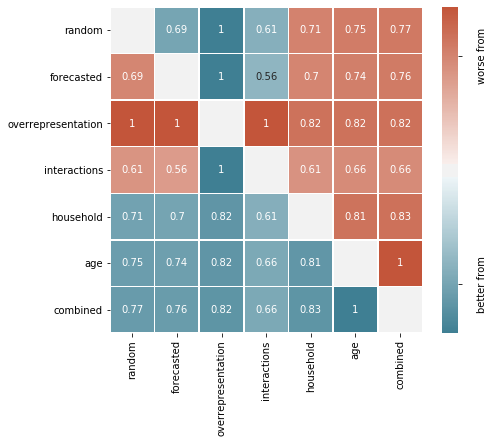

In [35]:
df_crossing = pd.DataFrame(x_crossing_dict_x)
df_crossing_direction = pd.DataFrame(x_crossing_direction_dict_x)

fig,ax= plt.subplots(1,1, figsize=(7,6))
sns.heatmap(df_crossing_direction, cmap=cmap, linewidths=0.5,
            vmin=-1, vmax=1,
            annot=label, #cbar_kws={'label': 'fraction of non-susceptible persons'},
            ax=ax)
#sns.heatmap(df_crossing, cmap=cmap, linewidths=0.5,
#            vmin=-1, vmax=1, alpha=0.0,
#            annot=True, cbar=False,
#            ax=ax)

for p in ax.texts:
    x,y = p.get_position()
    if x==y:
        p.set_text('')
        
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.7,0.7])
#colorbar.set_ticklabels(['perfoms better until', 'performs worse until'])   
colorbar.ax.set_yticklabels(['better from', 'worse from'], rotation=90,  va='center' )
colorbar.ax.tick_params(axis='y', which='major', pad=15)

In [36]:
df_dir_new = df_crossing_direction.iloc[:, ::-1]
df_crossing_new = df_crossing.iloc[:, ::-1]

In [100]:
df_crossing_new

,combined,age,household,interactions,overrepresentation,forecasted,random
random,0.770707,0.750505,0.714141,0.605051,1.000000,0.689899,-1.000000
forecasted,0.758586,0.738384,0.697980,0.560606,1.000000,-1.000000,0.689899
overrepresentation,0.823232,0.819192,0.819192,1.000000,-1.000000,1.000000,1.000000
interactions,0.657576,0.657576,0.613131,-1.000000,1.000000,0.560606,0.605051
household,0.827273,0.807071,-1.000000,0.613131,0.819192,0.697980,0.714141
age,1.000000,-1.000000,0.807071,0.657576,0.819192,0.738384,0.750505
combined,-1.000000,1.000000,0.827273,0.657576,0.823232,0.758586,0.770707


In [101]:
mask.T[:,::-1]

array([[False, False, False, False, False, False, False, False, False,
         True],
       [False, False, False, False, False, False, False, False,  True,
         True],
       [False, False, False, False, False, False, False,  True,  True,
         True],
       [False, False, False, False, False, False,  True,  True,  True,
         True],
       [False, False, False, False, False,  True,  True,  True,  True,
         True],
       [False, False, False, False,  True,  True,  True,  True,  True,
         True],
       [False, False, False,  True,  True,  True,  True,  True,  True,
         True],
       [False, False,  True,  True,  True,  True,  True,  True,  True,
         True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

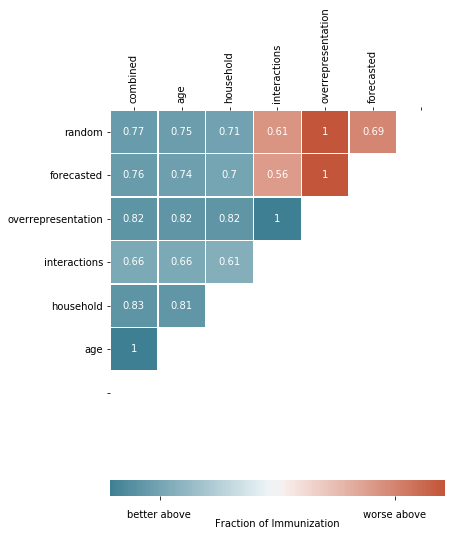

In [40]:
mask = np.zeros_like(df_crossing_new.values, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask_new = mask[:,::-1]

label = df_crossing_new.values
fig,ax= plt.subplots(1,1, figsize=(6,8))
sns.heatmap(df_dir_new*-1, cmap=cmap, linewidths=0.5,
            vmin=-1, vmax=1,
            annot=label, #cbar_kws={'label': 'fraction of non-susceptible persons'},
            mask=mask.T[:,::-1],
            ax=ax,
            cbar_kws = {'orientation':'horizontal'},)
#sns.heatmap(df_crossing, cmap=cmap, linewidths=0.5,
#            vmin=-1, vmax=1, alpha=0.0,
#            annot=True, cbar=False,
#            ax=ax)

for p in ax.texts:
    x,y = p.get_position()
    if x==7-y:
        p.set_text('')
ax.tick_params(axis='x', which='major',labelbottom = False, bottom=False, top = True, labeltop=True, rotation=90)
xticks = ax.get_xticklabels()
xticks[-1].set_visible(False)
yticks = ax.get_yticklabels()
yticks[-1].set_visible(False)
        
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.7,0.7])
#colorbar.set_ticklabels(['perfoms better until', 'performs worse until'])   
colorbar.ax.set_xticklabels(['better above ', 'worse above'],   va='center' )
colorbar.ax.set_xlabel('Fraction of Immunization',  va='center' )

colorbar.ax.tick_params(axis='x', which='major', pad=15,)

In [383]:
xticks = ax.get_xticklabels()
xticks[-1].set_visible(False)

In [328]:
mask = np.zeros_like(df_crossing_new.values, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[:,::-1]

array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True, False],
       [ True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True, False, False, False],
       [ True,  True,  True, False, False, False, False],
       [ True,  True, False, False, False, False, False],
       [ True, False, False, False, False, False, False]])

### pareto front?

In [245]:
#pareto_dict = {x:([],[]) for x in df_D_m.index}

In [13]:

1-df_m[0.5]
#[df_D_mx for x in df_D_m.index]
for x in pareto_dict:
    pareto_dict[x][0].append(1-df_m[x])
    pareto_dict[x][1].append(df_D_m[x])

In [14]:
pareto_dict

{0.5: ([0.0,
   0.06999999999999995,
   0.010000000000000009,
   0.0,
   0.0,
   0.030000000000000027,
   0.0,
   0.10801624129930398],
  [0.0065061871616395985,
   0.008866976024748643,
   0.01301624129930395,
   0.010864269141531322,
   0.004137664346481053,
   0.0008642691415313231,
   0.0007811291569992268,
   0.0007811291569992268]),
 0.54: ([0.010000000000000009,
   0.040000000000000036,
   0.030000000000000027,
   0.040000000000000036,
   0.010000000000000009,
   0.0,
   0.0,
   0.12837536780159697],
  [0.006000420344682638,
   0.008598150483396384,
   0.013251366120218582,
   0.009426229508196719,
   0.00399747793190416,
   0.0008343841950399331,
   0.0008175704077343423,
   0.0008175704077343423]),
 0.58: ([0.010000000000000009,
   0.09999999999999998,
   0.15000000000000002,
   0.09999999999999998,
   0.010000000000000009,
   0.020000000000000018,
   0.010000000000000009,
   0.17018646408839788],
  [0.004907918968692448,
   0.007778545119705339,
   0.01219843462246777,
   0.0

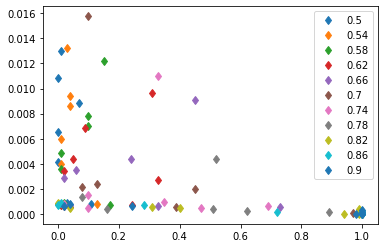

In [15]:
for key in pareto_dict:
    plt.plot(pareto_dict[key][0],pareto_dict[key][1],'d', label=key)
plt.legend()    